## MCDA for Tree and Scrub Placement Using Natural Capital Layers


In [1]:
# imports

import os
import glob
import rasterio
from rasterio.features import rasterize
from rasterio.plot import show
from rasterstats import zonal_stats
from shapely.geometry import box
from shapely.ops import unary_union 
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

## Pre cut the NC layers using GIS to the sample area from the overall 121 km squares (ROI)

In [29]:
# File paths
grid_path = "../data/boundaries/morridge_grid/morr_OS_bng_grid_1km.shp"
habitat_path = "../data/boundaries/MHC_Utopia_Stage_2/MHC_Utopia_Stage_2.shp"
clip_polygon_path = "../data/boundaries/nc_clip_area.shp"  # Output file

# Load the habitat and grid shapefiles
habitats = gpd.read_file(habitat_path).to_crs(epsg=27700)
grid = gpd.read_file(grid_path).to_crs(epsg=27700)

# Select grid cells that intersect with the habitat polygons
intersecting_tiles = grid[grid.intersects(habitats.unary_union)]

# Merge selected grid tiles into one polygon
merged_polygon = gpd.GeoDataFrame(geometry=[unary_union(intersecting_tiles.geometry)], crs=habitats.crs)

# Save to shapefile
merged_polygon.to_file(clip_polygon_path)

print(f"Clipping polygon saved: {clip_polygon_path}")

Clipping polygon saved: ../data/boundaries/nc_clip_area.shp


/tmp/ipykernel_3822/1645963593.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersecting_tiles = grid[grid.intersects(habitats.unary_union)]


### Step 1 different vrts for analysis, LULC and visualisation

In [8]:
#### Visualisation vrt using ADP

aerial_vrt = "../data/aerial_vrt.vrt"
aerial_folder = "../data/adp"

# List all aerial imagery files
aerial_files = " ".join([os.path.join(aerial_folder, f) for f in os.listdir(aerial_folder) if f.endswith(".tif")])

# Build the VRT dynamically
os.system(f"gdalbuildvrt -resolution highest -r cubic -overwrite {aerial_vrt} {aerial_files}")

print(f"Aerial Imagery VRT created: {aerial_vrt}")

0...10...20...30...40...50...60...70...80...90...100 - done.
Aerial Imagery VRT created: ../data/aerial_vrt.vrt


In [15]:
# Define the analusis VRT path
analysis_vrt = "../data/analysis_vrt.vrt"
converted_folder = "../data/nc_clipped"

# List all converted NC raster files
converted_files = " ".join([os.path.join(converted_folder, f) for f in os.listdir(converted_folder) if f.endswith(".tif")])

# Build the VRT with consistent Float32 data type
os.system(f"gdalbuildvrt -resolution average -r bilinear -overwrite {analysis_vrt} {converted_files}")

print(f"✅ Analysis VRT created successfully: {analysis_vrt}")


0...10...20...30...40...50...60...70...80...90...100 - done.
✅ Analysis VRT created successfully: ../data/analysis_vrt.vrt


In [3]:
# vrt for land cover
land_cover_vrt = "../data/land_cover_vrt.vrt"
land_cover_folder = "../data/Land-Cover/"

# List all land cover TIFFs
land_cover_files = " ".join(
    [os.path.join(land_cover_folder, f) for f in os.listdir(land_cover_folder) if f.endswith(".tif")]
)

# Build VRT dynamically
os.system(f"gdalbuildvrt -resolution highest -r mode -overwrite {land_cover_vrt} {land_cover_files}")

print(f"LC VRT created: {land_cover_vrt}")

0...10...20...30...40...50...60...70...80...90...100 - done.
LC VRT created: ../data/land_cover_vrt.vrt


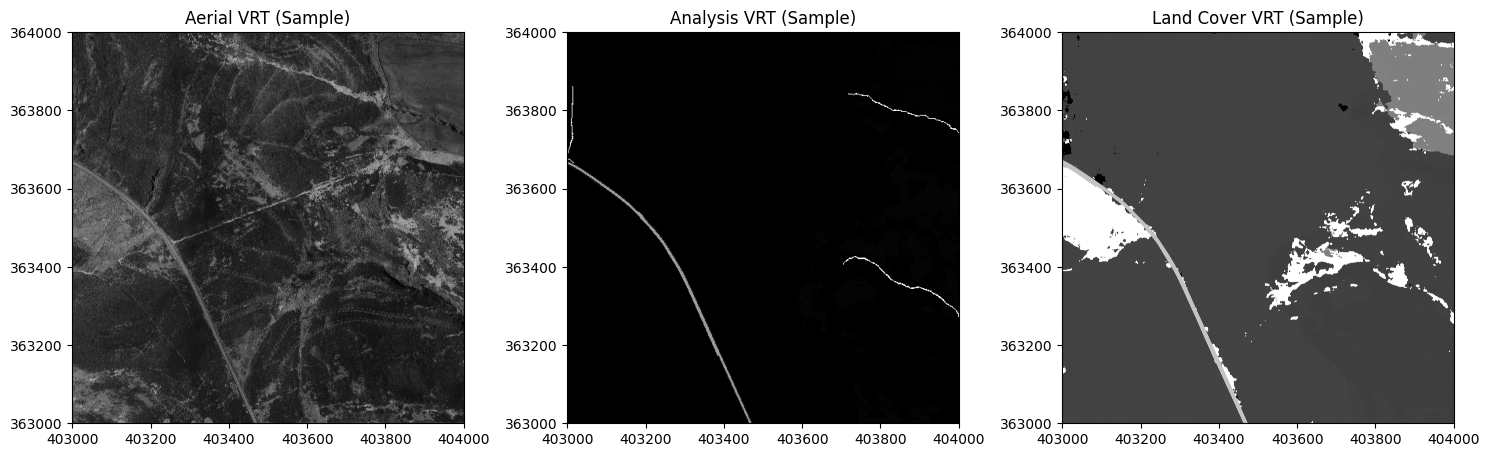

In [27]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from rasterio.plot import show

# Define VRT paths
aerial_vrt = "../data/aerial_vrt.vrt"
analysis_vrt = "../data/analysis_vrt.vrt"
land_cover_vrt = "../data/land_cover_vrt.vrt"

# Define a common area (small bounding box for visualization)
xmin, ymin, xmax, ymax = 403000, 363000, 404000, 364000  # Adjust for a suitable area

# Function to extract and plot a sample from each VRT
def plot_sample_vrt(vrt_path, title, ax, xmin, ymin, xmax, ymax):
    with rasterio.open(vrt_path) as src:
        # Convert bounding box to raster window
        window = from_bounds(xmin, ymin, xmax, ymax, src.transform)
        
        # Read data within the window
        data = src.read(1, window=window)
        
        # Get transform for the extracted window
        transform = src.window_transform(window)

    # Plot data
    show(data, transform=transform, cmap="gray", ax=ax)
    ax.set_title(title)

# Create figure and axes
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot samples from each VRT using the same spatial extent
plot_sample_vrt(aerial_vrt, "Aerial VRT (Sample)", axes[0], xmin, ymin, xmax, ymax)
plot_sample_vrt(analysis_vrt, "Analysis VRT (Sample)", axes[1], xmin, ymin, xmax, ymax)
plot_sample_vrt(land_cover_vrt, "Land Cover VRT (Sample)", axes[2], xmin, ymin, xmax, ymax)

plt.tight_layout()
plt.show()



In [25]:
import rasterio

vrt_paths = {
    "Aerial VRT": "../data/aerial_vrt.vrt",
    "Analysis VRT": "../data/analysis_vrt.vrt",
    "Land Cover VRT": "../data/land_cover_vrt.vrt"
}

for name, path in vrt_paths.items():
    with rasterio.open(path) as src:
        print(f"{name} - Pixel Size: {src.res[0]} x {src.res[1]}")


Aerial VRT - Pixel Size: 0.125 x 0.125
Analysis VRT - Pixel Size: 2.0 x 2.0
Land Cover VRT - Pixel Size: 0.125 x 0.125


In [24]:
for name, path in vrt_paths.items():
    with rasterio.open(path) as src:
        print(f"{name} Bounds: {src.bounds}")
        print(f"{name} Transform: {src.transform}\n")


Aerial VRT Bounds: BoundingBox(left=396000.0, bottom=357000.0, right=411000.0, top=370000.0)
Aerial VRT Transform: | 0.12, 0.00, 396000.00|
| 0.00,-0.12, 370000.00|
| 0.00, 0.00, 1.00|

Analysis VRT Bounds: BoundingBox(left=396000.0, bottom=357000.0, right=411000.0, top=370000.0)
Analysis VRT Transform: | 2.00, 0.00, 396000.00|
| 0.00,-2.00, 370000.00|
| 0.00, 0.00, 1.00|

Land Cover VRT Bounds: BoundingBox(left=396000.0, bottom=357000.0, right=411000.0, top=370000.0)
Land Cover VRT Transform: | 0.12, 0.00, 396000.00|
| 0.00,-0.12, 370000.00|
| 0.00, 0.00, 1.00|



## Step 2 take a look at the data

In [31]:
habitats.head(2)

,land_manag,mhc_id,currentpha,utopiaphas,notes,interventi,interven_1,interven_2,utopiaukha,utopiauk_1,SHAPE__Len,SHAPE__Are,hectares,percent_sc,percent_wo,geometry
0,Big Fernyford Farm,12-BF-A,(RUSH PASTURE),MARSHY /ACID /NEUTRAL -MOSAIC SPECIES RICH GR...,These areas will be subject to a hydrological ...,None,None,None,None,None,2433.286663,212048.740054,7.641291,0,0,"POLYGON ((406572.916 361327.95, 406548.015 361..."
1,GAP FARM,4-GF,None,WOOD PASTURE,WOODPASTURE WITH SPECIES RICH GRASSLAND,None,None,None,None,None,3000.468232,145725.757099,5.256694,30,30,"POLYGON ((408913.337 358779.179, 408905.137 35..."


/tmp/ipykernel_3822/3576800531.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {habitat: plt.cm.get_cmap("tab20")(i / len(unique_habitats)) for i, habitat in enumerate(unique_habitats)}


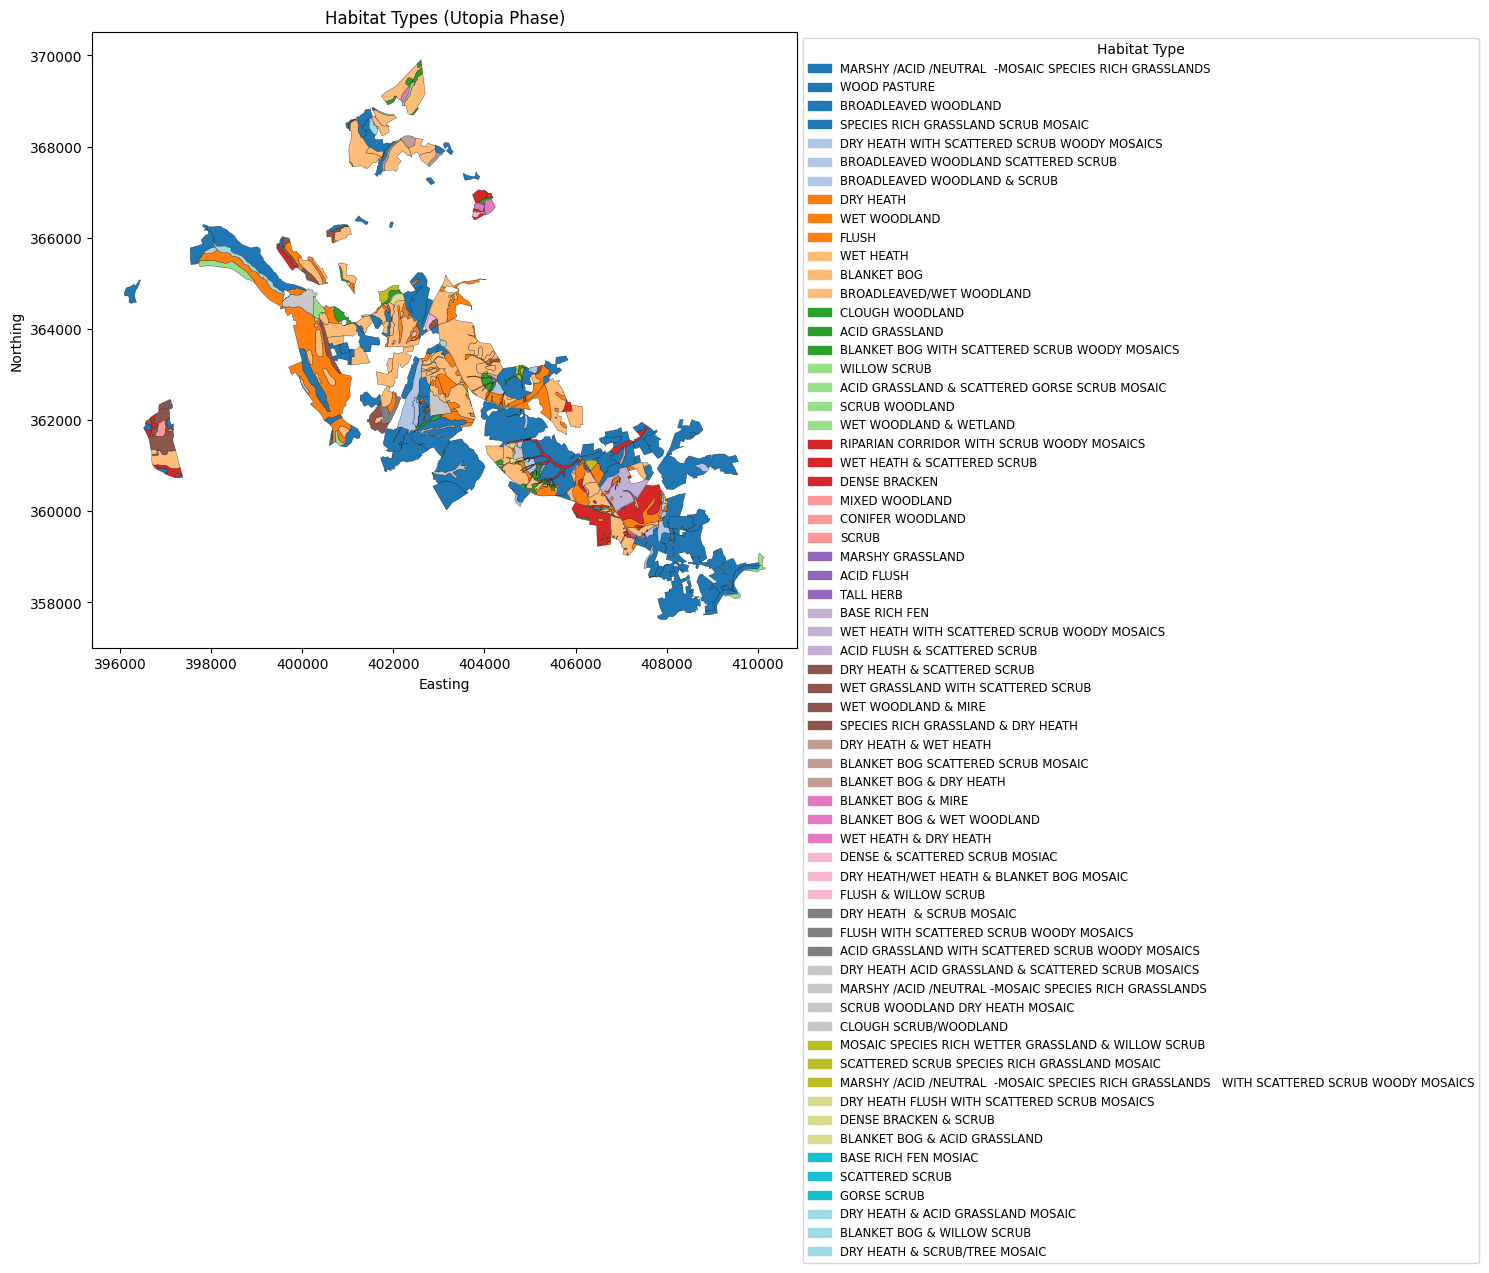

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File path
shapefile_path = "../data/boundaries/MHC_Utopia_Stage_2/MHC_Utopia_Stage_2.shp"

# Load the habitat and grid shapefiles
utopia_gdf = gpd.read_file(shapefile_path).to_crs(epsg=27700)

# Generate a unique color for each habitat type
unique_habitats = utopia_gdf["utopiaphas"].unique()
color_map = {habitat: plt.cm.get_cmap("tab20")(i / len(unique_habitats)) for i, habitat in enumerate(unique_habitats)}

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each habitat type with its assigned color
for habitat, color in color_map.items():
    utopia_gdf[utopia_gdf["utopiaphas"] == habitat].plot(ax=ax, color=color, edgecolor="black", linewidth=0.2)

# Manually create legend patches
legend_patches = [mpatches.Patch(color=color, label=habitat) for habitat, color in color_map.items()]

# Add legend
ax.legend(handles=legend_patches, title="Habitat Type", loc="upper left", fontsize="small", bbox_to_anchor=(1, 1))

# Labels
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title("Habitat Types (Utopia Phase)")

plt.show()

In [35]:
# File path
output_shapefile = "../data/boundaries/MHC_Utopia_Stage_2/MCDA_Polygons.shp"

# Filter polygons where percent_sc OR percent_wo > 0
mcda_polygons = utopia_gdf[(utopia_gdf["percent_sc"] > 0) | (utopia_gdf["percent_wo"] > 0)]

# Save filtered data to a new shapefile
mcda_polygons.to_file(output_shapefile)

print(f"MCDA polygons saved to: {output_shapefile}")
print(f"{len(mcda_polygons)} polygons selected for analysis.")


MCDA polygons saved to: ../data/boundaries/MHC_Utopia_Stage_2/MCDA_Polygons.shp
116 polygons selected for analysis.


/tmp/ipykernel_3822/800673462.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = {habitat: plt.cm.get_cmap("tab20")(i / len(unique_habitats)) for i, habitat in enumerate(unique_habitats)}


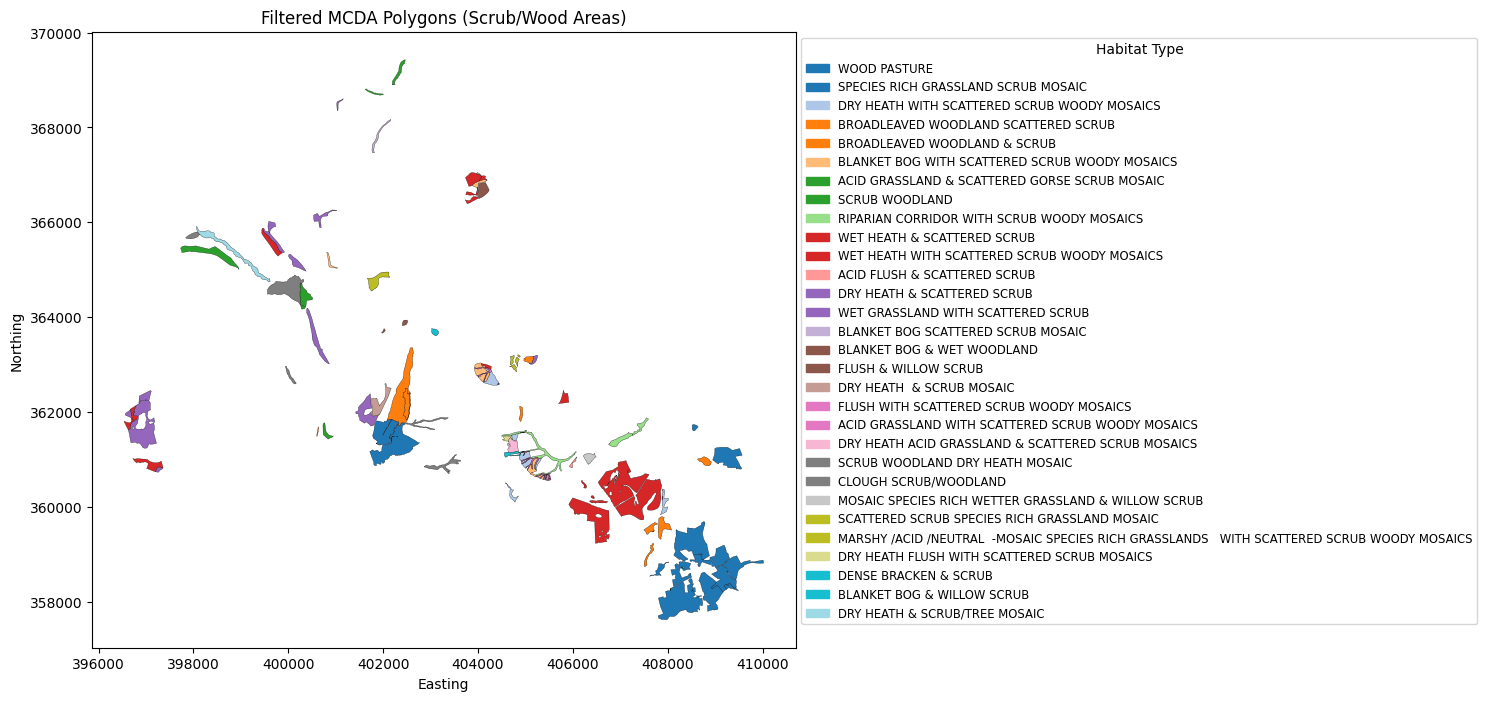

In [36]:
# Generate a unique color for each habitat type
unique_habitats = mcda_polygons["utopiaphas"].unique()
color_map = {habitat: plt.cm.get_cmap("tab20")(i / len(unique_habitats)) for i, habitat in enumerate(unique_habitats)}

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each habitat type with its assigned color
for habitat, color in color_map.items():
    mcda_polygons[mcda_polygons["utopiaphas"] == habitat].plot(ax=ax, color=color, edgecolor="black", linewidth=0.2)

# Manually create legend patches
legend_patches = [mpatches.Patch(color=color, label=habitat) for habitat, color in color_map.items()]

# Add legend
ax.legend(handles=legend_patches, title="Habitat Type", loc="upper left", fontsize="small", bbox_to_anchor=(1, 1))

# Labels
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")
ax.set_title("Filtered MCDA Polygons (Scrub/Wood Areas)")

plt.show()

# Step 2 Create a Final Normalised MCDA Raster

In [32]:
import rasterio
import numpy as np

# **File Paths**
nc_rasters = {
    "Carbon": "../data/nc_clipped/morr_C_tha_hiresf32_2cell.tif",
    "Water_Yield": "../data/nc_clipped/QF_morr_hr.tif",
    "Sediment_Avoided": "../data/nc_clipped/tha_avoided_erosion_hr125sq.tif",
    "Sediment_Export": "../data/nc_clipped/tha_sed_export_hr125sq.tif",
    "Sediment_Stream": "../data/nc_clipped/tha_stream_hr125sq.tif",
    "USLE": "../data/nc_clipped/tha_usle_hr125sq.tif"
}

# Open first raster to get metadata
with rasterio.open(nc_rasters["Carbon"]) as src:
    meta = src.meta.copy()
    meta.update(dtype=rasterio.float32, count=1)

# Normalize all rasters correctly (0 - 1 range)
normalized_rasters = {}

for name, raster_path in nc_rasters.items():
    with rasterio.open(raster_path) as src:
        raster = src.read(1).astype(float)
        raster[raster == src.nodata] = np.nan  # Mask nodata values
        
        # ✅ **Fix Scaling** (Proper 0 - 1 Normalization)
        raster_min, raster_max = np.nanmin(raster), np.nanmax(raster)
        normalized_rasters[name] = (raster - raster_min) / (raster_max - raster_min)
        
        # Clip to 0-1 to remove small floating errors
        normalized_rasters[name] = np.clip(normalized_rasters[name], 0, 1)

# ✅ **Improved Sediment Retention Score**
sediment_score = (
    (normalized_rasters["Sediment_Avoided"] + normalized_rasters["Sediment_Export"]) -
    (normalized_rasters["Sediment_Stream"] + normalized_rasters["USLE"])
)

# ✅ **Improved Suitability Calculation**
tree_suitability = (
    (1 - normalized_rasters["Carbon"]) * 0.4  # **Higher Carbon = Less Trees**
    + normalized_rasters["Water_Yield"] * 0.4
    + sediment_score * 0.4
)

scrub_suitability = (
    normalized_rasters["Water_Yield"] * 0.5  # **Slightly lower impact than before**
    + sediment_score * 0.5
)

# Clip Suitability Values to 0 - 1
tree_suitability = np.clip(tree_suitability, 0, 1)
scrub_suitability = np.clip(scrub_suitability, 0, 1)

# Save output rasters
output_tree = "../data/nc_clipped/MCDA_Tree_Suitability.tif"
output_scrub = "../data/nc_clipped/MCDA_Scrub_Suitability.tif"

with rasterio.open(output_tree, "w", **meta) as dst:
    dst.write(tree_suitability.astype(rasterio.float32), 1)

with rasterio.open(output_scrub, "w", **meta) as dst:
    dst.write(scrub_suitability.astype(rasterio.float32), 1)

print(f"🔥 MCDA Suitability Rasters saved: {output_tree}, {output_scrub}")
print(f"Tree Suitability Min: {np.nanmin(tree_suitability)}, Max: {np.nanmax(tree_suitability)}")
print(f"Scrub Suitability Min: {np.nanmin(scrub_suitability)}, Max: {np.nanmax(scrub_suitability)}")



🔥 MCDA Suitability Rasters saved: ../data/nc_clipped/MCDA_Tree_Suitability.tif, ../data/nc_clipped/MCDA_Scrub_Suitability.tif
Tree Suitability Min: 0.0, Max: 0.7991148262016148
Scrub Suitability Min: 0.0, Max: 0.7303339709166234


## Visualise the output

In [2]:
# build the vrts

# File paths
tree_suitability_raster = "../data/nc_clipped/MCDA_Tree_Suitability.tif"
scrub_suitability_raster = "../data/nc_clipped/MCDA_Scrub_Suitability.tif"
suitability_vrt = "../data/nc_clipped/MCDA_Suitability.vrt"

# Build VRT
os.system(f"gdalbuildvrt -resolution average -r bilinear -overwrite {suitability_vrt} {tree_suitability_raster} {scrub_suitability_raster}")

print(f"✅ Suitability VRT created successfully: {suitability_vrt}")

0...10...20...30...40...50...60...70...80...90...100 - done.
✅ Suitability VRT created successfully: ../data/nc_clipped/MCDA_Suitability.vrt


In [6]:
class_colors_combined = {
    0: ('#D3D3D3', 'No Class', '(nan)', 'Band 01'),  # Light grey
    101: ('#006400', 'Broadleaved Woodland', 'C101', 'Band 02'),  # Dark green
    102: ('#008000', 'Coniferous Woodland', 'C102', 'Band 03'),  # Green
    103: ('#808000', 'Scrub', 'C103', 'Band 04'),  # Olive
    104: ('#A52A2A', 'Felled/Young Trees', 'C104', 'Band 05'),  # Brown
    201: ('#800080', 'Heather Moorland', 'D201', 'Band 06'),  # Purple
    202: ('#A0522D', 'Upland Grass Moor', 'D202', 'Band 07'),  # Light brown
    203: ('#FFFF00', 'Bracken', 'D203', 'Band 08'),  # Yellow
    204: ('#FF8DA1', 'Mosaic', 'D204', 'Band 09'),  # Pink
    504: ('#FF0000', 'Rush Pasture', 'E504', 'Band 26'),  # Red
    302: ('#90EE90', 'Improved Grassland', 'E302', 'Band 13'),  # Light green
    303: ('#32CD32', 'Rough Grassland', 'E303', 'Band 14'),  # Lime green
    401: ('#0000FF', 'River', 'OS401', 'Band 15'),  # Blue
    402: ('#00FFFF', 'Lake', 'OS402', 'Band 16'),  # Cyan
    403: ('#ADD8E6', 'Pond', 'OS403', 'Band 17'),  # Light blue
    404: ('#808080', 'Suburban', 'OS404', 'Band 18'),  # Grey
    405: ('#808080', 'Cemeteries', 'OS405', 'Band 19'),  # Grey (same as Suburban)
    406: ('#90EE90', 'Playing Fields', 'OS406', 'Band 20'),  # Light green (same as Improved Grassland)
    407: ('#000000', 'Railway Verges', 'OS407', 'Band 21'),  # Black
    408: ('#000000', 'Railway', 'OS408', 'Band 22'),  # Black
    409: ('#000000', 'Road', 'OS409', 'Band 23'),  # Black
    410: ('#808080', 'Road Verges', 'OS410', 'Band 24'),  # Grey (same as Suburban)
    411: ('#000000', 'Dense Urban', 'OS411', 'Band 25'),  # Black
    205: ('#FF00FF', 'Heather Moorland on blanket bog/deep peat', 'D205', 'Band 10'),  # Magenta
    206: ('#FF1493', 'Upland Grass Moor on blanket bog/deep peat', 'D206', 'Band 11'), # Deep pink
    207: ('#FF69B4', 'Mosaic on blanket bog/deep peat', 'D207', 'Band 12')            # Hot pink
}

# Function to create colormap
def create_colormap(class_colors):
    values = sorted(class_colors.keys())
    colors = [class_colors[v][0] for v in values]
    return ListedColormap(colors), values

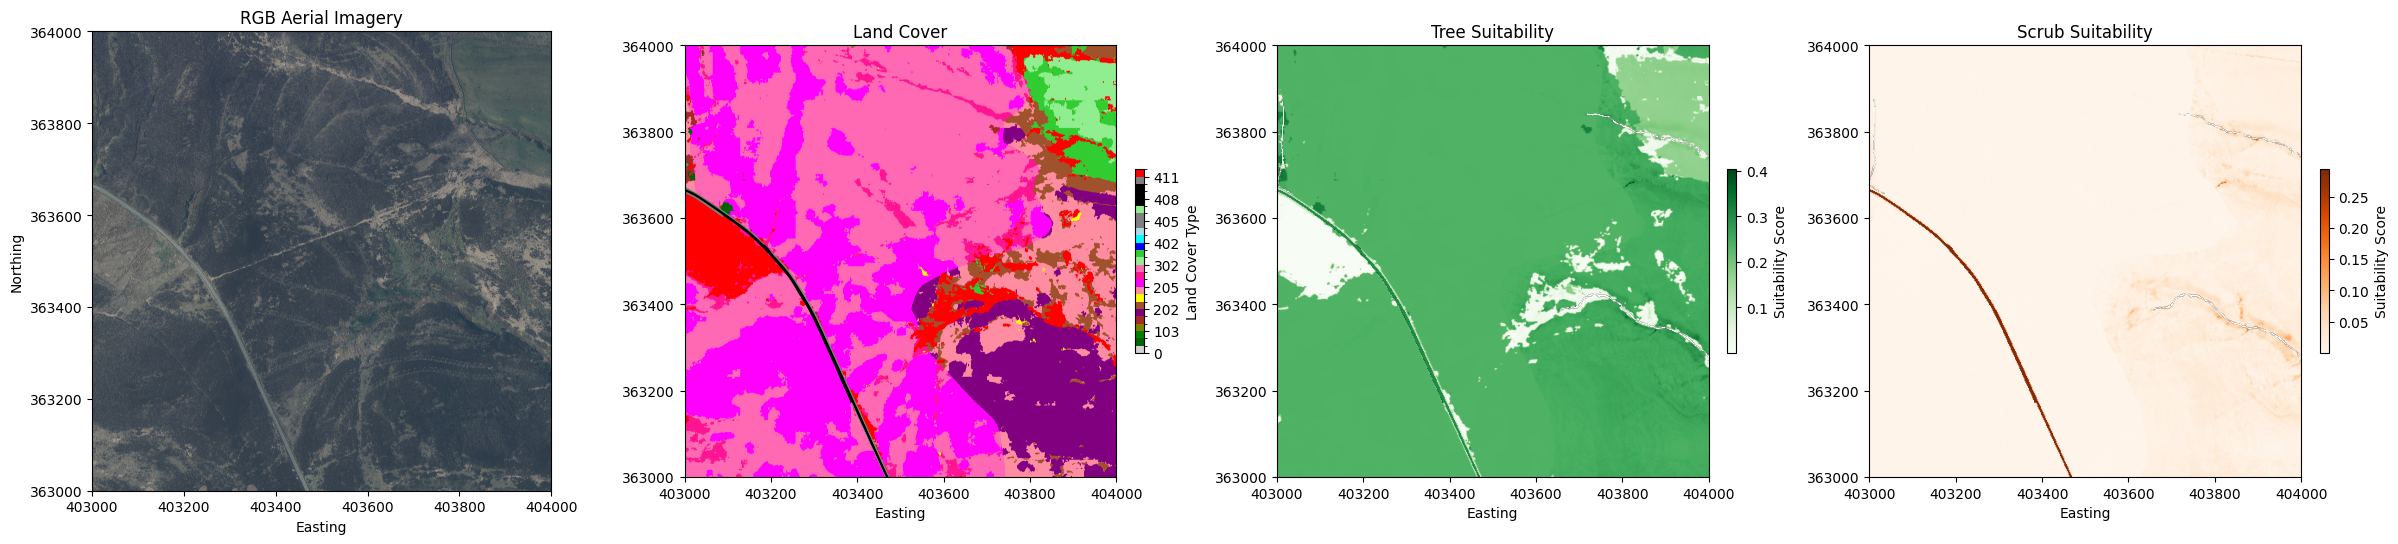

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.windows import from_bounds
from rasterio.plot import plotting_extent

# Define VRT paths
aerial_vrt = "../data/aerial_vrt.vrt"
land_cover_vrt = "../data/land_cover_vrt.vrt"
tree_suitability_raster = "../data/nc_clipped/MCDA_Tree_Suitability.tif"
scrub_suitability_raster = "../data/nc_clipped/MCDA_Scrub_Suitability.tif"

# Define a common area for visualization
xmin, ymin, xmax, ymax = 403000, 363000, 404000, 364000  

def extract_window(vrt_path, xmin, ymin, xmax, ymax, bands=None):
    """Extracts a subset from the raster given bounding box coordinates"""
    with rasterio.open(vrt_path) as src:
        window = from_bounds(xmin, ymin, xmax, ymax, src.transform)
        data = src.read(bands or [1], window=window)
        transform = src.window_transform(window)
        return data, transform

# Extract RGB Aerial Image
with rasterio.open(aerial_vrt) as src:
    aerial_rgb, aerial_transform = extract_window(aerial_vrt, xmin, ymin, xmax, ymax, bands=[1, 2, 3])

# Extract Land Cover Data
with rasterio.open(land_cover_vrt) as src:
    land_cover_data, land_cover_transform = extract_window(land_cover_vrt, xmin, ymin, xmax, ymax)

# Extract Suitability Rasters
tree_suit, tree_transform = extract_window(tree_suitability_raster, xmin, ymin, xmax, ymax)
scrub_suit, scrub_transform = extract_window(scrub_suitability_raster, xmin, ymin, xmax, ymax)

# Fix RGB Scaling
aerial_rgb = np.transpose(aerial_rgb, (1, 2, 0))  # Change (Bands, H, W) -> (H, W, Bands)
if aerial_rgb.dtype != np.uint8:
    aerial_rgb = ((aerial_rgb - aerial_rgb.min()) / (aerial_rgb.ptp()) * 255).astype(np.uint8)  # Normalize to 0-255

# Create Land Cover Colormap
lc_cmap, lc_values = create_colormap(class_colors_combined)
lc_norm = BoundaryNorm(lc_values, lc_cmap.N)

# Define colormaps for suitability
tree_cmap = plt.cm.Greens
scrub_cmap = plt.cm.Oranges

# Create figure
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# Plot RGB Aerial Imagery with Proper Extent
axes[0].imshow(aerial_rgb, extent=plotting_extent(aerial_rgb, aerial_transform))
axes[0].set_title("RGB Aerial Imagery")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")

# Plot Land Cover VRT
img0 = axes[1].imshow(land_cover_data[0], cmap=lc_cmap, norm=lc_norm, extent=plotting_extent(land_cover_data[0], land_cover_transform))
axes[1].set_title("Land Cover")
axes[1].set_xlabel("Easting")
cbar0 = plt.colorbar(img0, ax=axes[1], fraction=0.02, pad=0.04)
cbar0.set_label("Land Cover Type")

# Plot Tree Suitability
img1 = axes[2].imshow(tree_suit[0], cmap=tree_cmap, extent=plotting_extent(tree_suit[0], tree_transform))
axes[2].set_title("Tree Suitability")
axes[2].set_xlabel("Easting")
cbar1 = plt.colorbar(img1, ax=axes[2], fraction=0.02, pad=0.04)
cbar1.set_label("Suitability Score")

# Plot Scrub Suitability
img2 = axes[3].imshow(scrub_suit[0], cmap=scrub_cmap, extent=plotting_extent(scrub_suit[0], scrub_transform))
axes[3].set_title("Scrub Suitability")
axes[3].set_xlabel("Easting")
cbar2 = plt.colorbar(img2, ax=axes[3], fraction=0.02, pad=0.04)
cbar2.set_label("Suitability Score")

plt.tight_layout()
plt.show()

## Step 3 Generate Trees and scrub!

In [26]:
# look at the ranges within the polygons

import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask

# File Paths
mcda_shapefile = "../data/boundaries/MHC_Utopia_Stage_2/MCDA_Polygons.shp"
tree_suitability_raster = "../data/nc_clipped/MCDA_Tree_Suitability.tif"
scrub_suitability_raster = "../data/nc_clipped/MCDA_Scrub_Suitability.tif"

# Load MCDA Polygons
mcda_gdf = gpd.read_file(mcda_shapefile)

# Load rasters
with rasterio.open(tree_suitability_raster) as src_tree, \
     rasterio.open(scrub_suitability_raster) as src_scrub:

    for i, row in mcda_gdf.iterrows():
        polygon = row["geometry"]

        # Mask tree suitability
        tree_suit, _ = mask(src_tree, [polygon], crop=True)
        scrub_suit, _ = mask(src_scrub, [polygon], crop=True)

        # Flatten arrays
        tree_suit = tree_suit[0].flatten()
        scrub_suit = scrub_suit[0].flatten()

        # Filter out NaNs
        tree_suit = tree_suit[~np.isnan(tree_suit)]
        scrub_suit = scrub_suit[~np.isnan(scrub_suit)]

        print(f"Polygon {i+1} - Tree Suitability Min: {tree_suit.min() if len(tree_suit) > 0 else 'N/A'}, Max: {tree_suit.max() if len(tree_suit) > 0 else 'N/A'}")
        print(f"Polygon {i+1} - Scrub Suitability Min: {scrub_suit.min() if len(scrub_suit) > 0 else 'N/A'}, Max: {scrub_suit.max() if len(scrub_suit) > 0 else 'N/A'}")


Polygon 1 - Tree Suitability Min: -0.10939359664916992, Max: 0.3987154960632324
Polygon 1 - Scrub Suitability Min: 0.0, Max: 0.29271209239959717
Polygon 2 - Tree Suitability Min: -0.10444451123476028, Max: 0.27995193004608154
Polygon 2 - Scrub Suitability Min: 0.0, Max: 0.036447830498218536
Polygon 3 - Tree Suitability Min: -0.09748760610818863, Max: 0.44613561034202576
Polygon 3 - Scrub Suitability Min: 0.0, Max: 0.2795417308807373
Polygon 4 - Tree Suitability Min: -0.1083863154053688, Max: 0.47109147906303406
Polygon 4 - Scrub Suitability Min: -0.10136503726243973, Max: 0.35729774832725525
Polygon 5 - Tree Suitability Min: -0.10654223710298538, Max: 0.4023125171661377
Polygon 5 - Scrub Suitability Min: 0.0, Max: 0.24220488965511322
Polygon 6 - Tree Suitability Min: -0.1021052747964859, Max: 0.3063255846500397
Polygon 6 - Scrub Suitability Min: 0.0, Max: 0.08266738057136536
Polygon 7 - Tree Suitability Min: -0.10939805209636688, Max: 0.5595889091491699
Polygon 7 - Scrub Suitability Mi

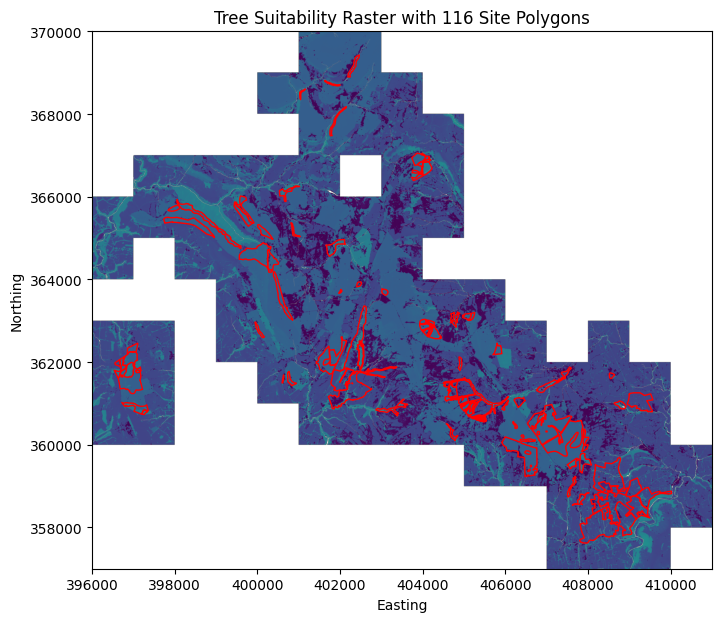

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

#test_polygon = mcda_gdf.iloc[0]["geometry"]
mcda_shapefile = "../data/boundaries/MHC_Utopia_Stage_2/MCDA_Polygons.shp"
tree_suitability_raster = "../data/nc_clipped/MCDA_Tree_Suitability.tif"
scrub_suitability_raster = "../data/nc_clipped/MCDA_Scrub_Suitability.tif"

mcda_gdf = gpd.read_file(mcda_shapefile)  # Load as GeoDataFrame

# === Open and Plot the Raster ===
with rasterio.open(tree_suitability_raster) as src:
    fig, ax = plt.subplots(figsize=(8, 8))  # Increased size for clarity

    # Plot 
    show(src.read(1), transform=src.transform, cmap="viridis", ax=ax)

    # Overlay 
    mcda_gdf.boundary.plot(ax=ax, color="red", linewidth=1)

    plt.title("Tree Suitability Raster with 116 Site Polygons")
    plt.xlabel("Easting")
    plt.ylabel("Northing")

    plt.show()

In [ ]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask
from shapely.geometry import Point, Polygon
import random
from scipy.spatial import ConvexHull

mcda_shapefile = "../data/boundaries/MHC_Utopia_Stage_2/MCDA_Polygons.shp"
tree_raster_path = "../data/nc_clipped/MCDA_Tree_Suitability.tif"
scrub_raster_path = "../data/nc_clipped/MCDA_Scrub_Suitability.tif"
output_combined_shapefile = "../data/Land-Cover-Predicted/Generated_Vegetation.shp"

# Load
mcda_gdf = gpd.read_file(mcda_shapefile)

# Open  Rasters
with rasterio.open(tree_raster_path) as src_tree, rasterio.open(scrub_raster_path) as src_scrub:
    tree_transform = src_tree.transform
    scrub_transform = src_scrub.transform
    
    # List to store final vegetation patches
    vegetation_patches = []

    for index, row in mcda_gdf.iterrows():
        polygon = row["geometry"]
        percent_wo = row["percent_wo"] / 100  # Convert to fraction
        percent_sc = row["percent_sc"] / 100

        # Extract suitability values inside polygon
        tree_suit, tree_transform = mask(src_tree, [polygon], crop=True)
        scrub_suit, scrub_transform = mask(src_scrub, [polygon], crop=True)

        # Flatten and Remove NoData Values
        tree_suit = tree_suit[0]
        scrub_suit = scrub_suit[0]

        tree_indices = np.where(np.isfinite(tree_suit))
        scrub_indices = np.where(np.isfinite(scrub_suit))

        tree_suit = tree_suit[tree_indices]
        scrub_suit = scrub_suit[scrub_indices]

        # Re-normalize per polygon (0-1)
        if len(tree_suit) > 0:
            tree_min, tree_max = np.min(tree_suit), np.max(tree_suit)
            tree_suit = (tree_suit - tree_min) / (tree_max - tree_min + 1e-6)

        if len(scrub_suit) > 0:
            scrub_min, scrub_max = np.min(scrub_suit), np.max(scrub_suit)
            scrub_suit = (scrub_suit - scrub_min) / (scrub_max - scrub_min + 1e-6)

        print(f"Polygon {index+1} - Tree Suitability: {np.min(tree_suit):.4f} to {np.max(tree_suit):.4f}")
        print(f"Polygon {index+1} - Scrub Suitability: {np.min(scrub_suit):.4f} to {np.max(scrub_suit):.4f}")

        # Calculate number of vegetation pixels needed
        total_area = polygon.area
        target_tree_area = total_area * percent_wo
        target_scrub_area = total_area * percent_sc

        tree_pixels_needed = int(target_tree_area / 30)  # Assume 30 m² per tree
        scrub_pixels_needed = int(target_scrub_area / 50)  # Assume 50 m² per scrub patch

        existing_patches = []

        # create random scrub patches
        def generate_scrub_patch(center, base_radius=10, variation=5):
            num_points = np.random.randint(8, 15)
            points = [
                (
                    center.x + np.random.uniform(-variation, variation),
                    center.y + np.random.uniform(-variation, variation)
                )
                for _ in range(num_points)
            ]
            try:
                hull = ConvexHull(points)
                return Polygon([points[i] for i in hull.vertices])
            except:
                return center.buffer(base_radius)  # Fallback to simple circle

        # Randomly distribute trees inside polygon
        tree_coords = list(zip(tree_indices[0], tree_indices[1]))
        random.shuffle(tree_coords)  # Shuffle for randomness

        current_tree_area = 0
        for row, col in tree_coords[:tree_pixels_needed]:
            x, y = tree_transform * (col, row)
            point = Point(x, y)
            tree_patch = point.buffer(np.random.uniform(2.5, 3.5))  # Random radius

            if polygon.contains(point) and not any(tree_patch.intersects(existing) for existing in existing_patches):
                vegetation_patches.append({"geometry": tree_patch, "type": "Tree"})
                existing_patches.append(tree_patch)
                current_tree_area += tree_patch.area
            if current_tree_area >= target_tree_area:
                break

        print(f"Polygon {index+1}: Tree Coverage Target Met ({current_tree_area:.2f} m² / {target_tree_area:.2f} m²)")

        # Randomly distribute scrub patches inside polygon
        scrub_coords = list(zip(scrub_indices[0], scrub_indices[1]))
        random.shuffle(scrub_coords)

        current_scrub_area = 0
        for row, col in scrub_coords[:scrub_pixels_needed]:
            x, y = scrub_transform * (col, row)
            point = Point(x, y)
            scrub_patch = generate_scrub_patch(point, base_radius=12, variation=6)

            if polygon.contains(point) and not any(scrub_patch.intersects(existing) for existing in existing_patches):
                vegetation_patches.append({"geometry": scrub_patch, "type": "Scrub"})
                existing_patches.append(scrub_patch)
                current_scrub_area += scrub_patch.area
            if current_scrub_area >= target_scrub_area:
                break

        print(f"Polygon {index+1}: Scrub Coverage Target Met ({current_scrub_area:.2f} m² / {target_scrub_area:.2f} m²)")


if vegetation_patches:
    vegetation_gdf = gpd.GeoDataFrame(vegetation_patches, geometry=[p["geometry"] for p in vegetation_patches], crs=mcda_gdf.crs)
    vegetation_gdf.to_file(output_combined_shapefile, driver="ESRI Shapefile")
    print(f"Vegetation (Trees & Scrub) Saved: {output_combined_shapefile}")
else:
    print("No vegetation patches generated. uh oh Dave.")



## Visualisation of generated scrub and trees

Selected Polygon: PDNPA (ID: 13-AS-M)


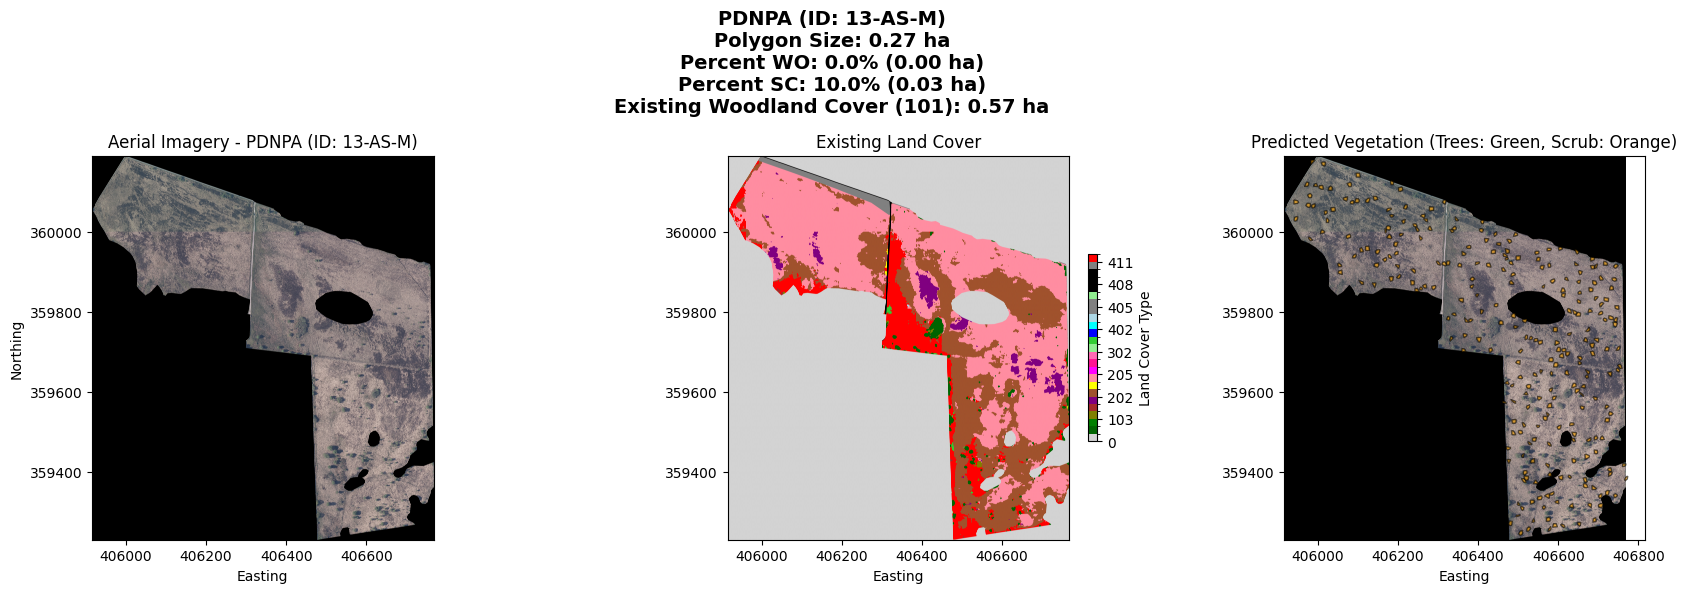

In [42]:
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.mask import mask
from rasterio.plot import plotting_extent

# === File Paths ===
mcda_shapefile = "../data/boundaries/MHC_Utopia_Stage_2/MCDA_Polygons.shp"
vegetation_shapefile = "../data/Land-Cover-Predicted/Generated_Vegetation.shp"
aerial_vrt = "../data/aerial_vrt.vrt"
land_cover_vrt = "../data/land_cover_vrt.vrt"

# === Load Polygons ===
mcda_gdf = gpd.read_file(mcda_shapefile)
vegetation_gdf = gpd.read_file(vegetation_shapefile)

# === Select One Polygon for Visualization ===
# Select the first polygon
selected_polygon = mcda_gdf.iloc[28]                                  
polygon_geom = selected_polygon["geometry"]

# Update column references to match actual column names
land_name = selected_polygon.get("land_manag", "Unknown")  # Replacing 'land_name' with 'land_manag'
mhc_id = selected_polygon.get("mhc_id", "Unknown")

print(f"Selected Polygon: {land_name} (ID: {mhc_id})")

# === Extract Raster Data for Selected Polygon ===
def extract_raster_data(raster_path, polygon_geom):
    """Extracts raster data within a given polygon"""
    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, [polygon_geom], crop=True)
        return out_image, out_transform

# Extract Aerial, Land Cover
aerial_rgb, aerial_transform = extract_raster_data(aerial_vrt, polygon_geom)
land_cover_data, land_cover_transform = extract_raster_data(land_cover_vrt, polygon_geom)

# === Normalize RGB for Aerial Image ===
aerial_rgb = np.transpose(aerial_rgb, (1, 2, 0))  # (Bands, H, W) -> (H, W, Bands)
if aerial_rgb.dtype != np.uint8:
    aerial_rgb = ((aerial_rgb - aerial_rgb.min()) / (aerial_rgb.ptp()) * 255).astype(np.uint8)

# === Create Land Cover Colormap ===
def create_colormap(class_colors):
    values = sorted(class_colors.keys())
    colors = [class_colors[v][0] for v in values]
    return ListedColormap(colors), values

lc_cmap, lc_values = create_colormap(class_colors_combined)
lc_norm = BoundaryNorm(lc_values, lc_cmap.N)

# Extract additional polygon attributes
polygon_size_ha = selected_polygon["hectares"]
percent_wo = selected_polygon["percent_wo"]
percent_sc = selected_polygon["percent_sc"]

# Convert percentages to hectares for comparison
wo_ha = (percent_wo / 100) * polygon_size_ha
sc_ha = (percent_sc / 100) * polygon_size_ha


# Extract Land Cover Data
with rasterio.open(land_cover_vrt) as src_landcover:
    land_cover_data, land_cover_transform = mask(src_landcover, [polygon_geom], crop=True)
    land_cover_res = src_landcover.res  # Extract resolution (pixel size)

# Extract existing woodland cover (code 101)
existing_woodland_cover = (land_cover_data[0] == 101).sum()  # Count woodland pixels

# Convert pixel count to hectares (resolution = meters per pixel)
existing_woodland_ha = existing_woodland_cover * (land_cover_res[0] * land_cover_res[1]) / 10_000  # Convert m² to ha


# Generate the new title
title_text = (
    f"{land_name} (ID: {mhc_id})\n"
    f"Polygon Size: {polygon_size_ha:.2f} ha\n"
    f"Percent WO: {percent_wo:.1f}% ({wo_ha:.2f} ha)\n"
    f"Percent SC: {percent_sc:.1f}% ({sc_ha:.2f} ha)\n"
    f"Existing Woodland Cover (101): {existing_woodland_ha:.2f} ha"
)

# === Extract Vegetation for Selected Polygon ===
polygon_vegetation = vegetation_gdf[vegetation_gdf.intersects(polygon_geom)]

# === Create Plot ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Set the title in your figure
fig.suptitle(title_text, fontsize=14, fontweight="bold")

# Aerial Image
axes[0].imshow(aerial_rgb, extent=plotting_extent(aerial_rgb, aerial_transform))
axes[0].set_title(f"Aerial Imagery - {land_name} (ID: {mhc_id})")
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Northing")

# Land Cover
img1 = axes[1].imshow(land_cover_data[0], cmap=lc_cmap, norm=lc_norm, extent=plotting_extent(land_cover_data[0], land_cover_transform))
axes[1].set_title("Existing Land Cover")
axes[1].set_xlabel("Easting")
cbar1 = plt.colorbar(img1, ax=axes[1], fraction=0.02, pad=0.04)
cbar1.set_label("Land Cover Type")

# Predicted Vegetation
axes[2].imshow(aerial_rgb, extent=plotting_extent(aerial_rgb, aerial_transform))  # Background
polygon_vegetation.plot(ax=axes[2], color=polygon_vegetation["type"].map({"Tree": "green", "Scrub": "orange"}), alpha=0.6, edgecolor="black")
axes[2].set_title("Predicted Vegetation (Trees: Green, Scrub: Orange)")
axes[2].set_xlabel("Easting")

plt.tight_layout()
plt.show()



In [31]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask

# **File Paths**
mcda_shapefile = "../data/boundaries/MHC_Utopia_Stage_2/MCDA_Polygons.shp"
tree_suitability_raster = "../data/nc_clipped/MCDA_Tree_Suitability.tif"
scrub_suitability_raster = "../data/nc_clipped/MCDA_Scrub_Suitability.tif"

# **Load Polygons**
mcda_gdf = gpd.read_file(mcda_shapefile)

# **Check Raster CRS**
with rasterio.open(tree_suitability_raster) as src_tree:
    tree_crs = src_tree.crs
    tree_bounds = src_tree.bounds

with rasterio.open(scrub_suitability_raster) as src_scrub:
    scrub_crs = src_scrub.crs
    scrub_bounds = src_scrub.bounds

print(f"🗺️ Polygon CRS: {mcda_gdf.crs}")
print(f"🌳 Tree Raster CRS: {tree_crs}, Bounds: {tree_bounds}")
print(f"🌿 Scrub Raster CRS: {scrub_crs}, Bounds: {scrub_bounds}")

# **Check Suitability Values for Each Polygon**
for i, row in mcda_gdf.iterrows():
    polygon = row["geometry"]
    
    # ✅ Extract Tree Suitability
    with rasterio.open(tree_suitability_raster) as src_tree:
        tree_suit, _ = mask(src_tree, [polygon], crop=True)
        tree_suit = tree_suit[0]
    
    # ✅ Extract Scrub Suitability
    with rasterio.open(scrub_suitability_raster) as src_scrub:
        scrub_suit, _ = mask(src_scrub, [polygon], crop=True)
        scrub_suit = scrub_suit[0]
    
    # **Print Statistics**
    print(f"Polygon {i+1} - Tree Suitability Min: {np.nanmin(tree_suit)}, Max: {np.nanmax(tree_suit)}")
    print(f"Polygon {i+1} - Scrub Suitability Min: {np.nanmin(scrub_suit)}, Max: {np.nanmax(scrub_suit)}")


🗺️ Polygon CRS: EPSG:27700
🌳 Tree Raster CRS: EPSG:27700, Bounds: BoundingBox(left=396000.0, bottom=357000.0, right=411000.0, top=370000.0)
🌿 Scrub Raster CRS: EPSG:27700, Bounds: BoundingBox(left=396000.0, bottom=357000.0, right=411000.0, top=370000.0)
Polygon 1 - Tree Suitability Min: -0.10939359664916992, Max: 0.3987154960632324
Polygon 1 - Scrub Suitability Min: 0.0, Max: 0.29271209239959717
Polygon 2 - Tree Suitability Min: -0.10444451123476028, Max: 0.27995193004608154
Polygon 2 - Scrub Suitability Min: 0.0, Max: 0.036447830498218536
Polygon 3 - Tree Suitability Min: -0.09748760610818863, Max: 0.44613561034202576
Polygon 3 - Scrub Suitability Min: 0.0, Max: 0.2795417308807373
Polygon 4 - Tree Suitability Min: -0.1083863154053688, Max: 0.47109147906303406
Polygon 4 - Scrub Suitability Min: -0.10136503726243973, Max: 0.35729774832725525
Polygon 5 - Tree Suitability Min: -0.10654223710298538, Max: 0.4023125171661377
Polygon 5 - Scrub Suitability Min: 0.0, Max: 0.24220488965511322
Po